**CURSO**: Análisis Geoespacial, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Classroom code**: [32cjlau] <br />
**Credits**: The content of this notebook is taken from several sources, such as [Muntasir Wahed](https://medium.com/analytics-vidhya/the-beginners-guide-to-choropleth-maps-in-python-ff1da28a8943), but specially from the courses and book open and freely published by [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool & - Sergio Rey - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu/peopleRey.html). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions. 

# Exploratory Spatial Data Analysis (ESDA)

In this session we will learn how to explore spatial autocorrelation in a given dataset, interrogating the data about its presence, nature, and strength. To do this, we will use a set of tools collectively known as Exploratory Spatial Data Analysis (ESDA), specifically designed for this purpose. The range of ESDA methods is very wide and spans from less sophisticated approaches like choropleths and general table querying, to more advanced and robust methodologies that include statistical inference and an explicit recognition of the geographical dimension of the data. The purpose of this session is to dip our toes into the latter group.

ESDA techniques are usually divided into two main groups: tools to analyze *global*, and *local* spatial autocorrelation. The former consider the overall trend that the location of values follows, and makes possible statements about the degree of *clustering* in the dataset. *Do values generally follow a particular pattern in their geographical distribution*? *Are similar values closer to other similar values than we would expect from pure chance?* These are some of the questions that tools for global spatial autocorrelation allow to answer. We will practice with global spatial autocorrelation by using Moran's I statistic.

Tools for *local* spatial autocorrelation instead focus on spatial instability: the departure of parts of a map from the general trend. The idea here is that, even though there is a given trend for the data in terms of the nature and strength of spatial association, some particular areas can diverege quite substantially from the general pattern. Regardless of the overall degree of concentration in the values, we can observe pockets of unusually high (low) values close to other high (low) values, in what we will call hot(cold)spots. Additionally, it is also possible to observe some high (low) values surrounded by low (high) values, and we will name these "spatial outliers". The main technique we will review in this session to explore local spatial autocorrelation is the Local Indicators of Spatial Association (LISA).

In [2]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran
#from pysal.viz.splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

## Data

For this session, we will use a current dataset: the results of the 2016 referendum vote to leave the EU, at the local authority level. In particular, we will focus on the spatial distribution of the vote to Leave, which ended up winning. From a technical point of view, you will be working with polygons which have a value (the percentage of the electorate that voted to Leave the EU) attached to them.

All the necessary data have been assembled for convenience in a single file that contains geographic information about each local authority in England, Wales and Scotland, as well as the vote attributes. The file is in the modern geospatial format [GeoPackage](http://www.geopackage.org/), which presents several advantages over the more traditional shapefile (chief among them, the need of a single file instead of several). The file is available as a download from the course website on the following link:

In [3]:
br_path = 'http://darribas.org/gds19/content/labs/data/brexit.gpkg'

### Loading and exploring the data

We can load and manipulate them in exactly the same terms as with polygon files:

In [4]:
# Load local Authority geometries using their ID code as index
br = gpd.read_file(br_path).set_index('LAD14CD', drop=False)
br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    380 non-null    int64   
 1   LAD14CD     380 non-null    object  
 2   LAD14NM     380 non-null    object  
 3   LAD14NMW    22 non-null     object  
 4   id          380 non-null    int64   
 5   Region_Cod  380 non-null    object  
 6   Region      380 non-null    object  
 7   Area        380 non-null    object  
 8   Electorate  380 non-null    int64   
 9   ExpectedBa  380 non-null    int64   
 10  VerifiedBa  380 non-null    int64   
 11  Pct_Turnou  380 non-null    float64 
 12  Votes_Cast  380 non-null    int64   
 13  Valid_Vote  380 non-null    int64   
 14  Remain      380 non-null    int64   
 15  Leave       380 non-null    int64   
 16  Rejected_B  380 non-null    int64   
 17  No_officia  380 non-null    int64   
 18  Voting_for  380 non-null    int64

Although there are several variables that could be considered, we will focus on Pct_Leave, which measures the proportion of votes for the Leave alternative. For convenience, let us merge the vote results with the spatial data:

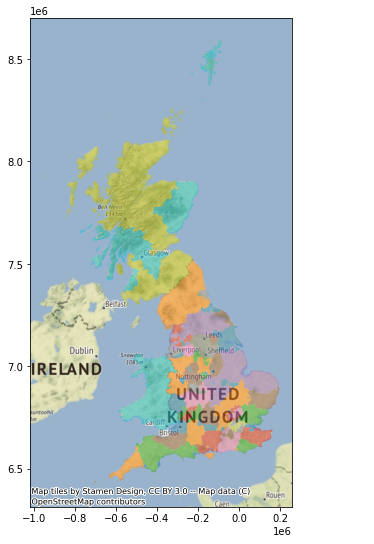

In [10]:
ax = br.plot(column="LAD14CD", figsize=(9, 9), alpha=0.5);
# Add background map, expressing target CRS so the basemap can be
# reprojected (warped)
ctx.add_basemap(ax, crs=br.crs)

And, since it is a full-fledge `GeoDataFrame`, we can also inspect its top rows:

In [6]:
br.head()

,OBJECTID,LAD14CD,LAD14NM,LAD14NMW,id,Region_Cod,Region,Area,Electorate,ExpectedBa,...,Leave,Rejected_B,No_officia,Voting_for,Writing_or,Unmarked_o,Pct_Remain,Pct_Leave,Pct_Reject,geometry
LAD14CD,,,,,,,,,,,,,,,,,,,,,
E06000001,1,E06000001,Hartlepool,None,70,E12000001,North East,Hartlepool,70341,46137,...,32071,34,0,12,6,16,30.43,69.57,0.07,"MULTIPOLYGON (((-141202.225 7308889.307, -1411..."
E06000002,2,E06000002,Middlesbrough,None,71,E12000001,North East,Middlesbrough,94612,61395,...,40177,35,0,16,1,18,34.52,65.48,0.06,"MULTIPOLYGON (((-139272.615 7282988.170, -1390..."
E06000003,3,E06000003,Redcar and Cleveland,None,72,E12000001,North East,Redcar and Cleveland,103529,72741,...,48128,27,0,6,0,21,33.81,66.19,0.04,"MULTIPOLYGON (((-126494.218 7293275.078, -1264..."
E06000004,4,E06000004,Stockton-on-Tees,None,73,E12000001,North East,Stockton-on-Tees,141486,100462,...,61982,45,2,13,2,28,38.27,61.73,0.04,"MULTIPOLYGON (((-146637.970 7293230.452, -1466..."
E06000005,5,E06000005,Darlington,None,74,E12000001,North East,Darlington,77662,55194,...,30994,29,0,0,0,29,43.82,56.18,0.05,"MULTIPOLYGON (((-182304.320 7287910.300, -1823..."


Before we move on to the analytical part, we can also create a choropleth map:

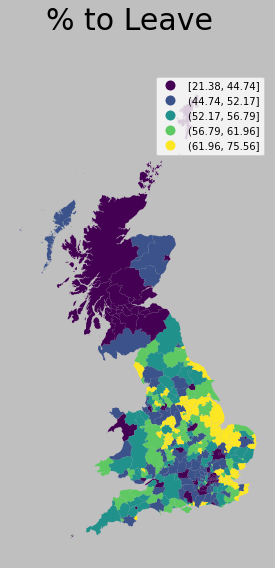

In [7]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot % to leave
br.plot(column='Pct_Leave', scheme='Quantiles', 
        legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.75')
# Title
f.suptitle('% to Leave', size=30)
# Draw
plt.show()

## Spatial autocorrelation

Spatial autocorrelation has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. Not completely unlike the traditional correlation between two variables -which informs us about how the values in one variable change as a function of those in the other- and analogous to its time-series counterpart -which relates the value of a variable at a given point in time with those in previous periods-, spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in surrounding locations.

A key idea in this context is that of spatial randomness: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if it is distributed following no discernible pattern over space. Spatial autocorrelation can thus be formally defined as the "absence of spatial randomness", which gives room for two main classes of autocorrelation, similar to the traditional case: *positive* spatial autocorrelation, when similar values tend to group together in similar locations; and *negative* spatial autocorrelation, in cases where similar values tend to be dispersed and further apart from each other.

La herramienta fundamental para evaluar la relación espacial entre observaciones corresponde a la matriz espacial de pesos. La matriz de pesos tiene dimensiones de $N$ by $N$, donde $N$ es el número total de observaciones:

$$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)
$$

Donde cada celda $w_{ij}$ corresponde a un valor que representa el grado espacial de contacto o interaccion entre los valores $i$ y $j$. Por convension la diagonal ($w_{ij}$) son ceros. El valor $W$, de $i$ y $j$ son vecinas si $w_{ij} > 0$.


A spatial weights matrix is the way geographical space is formally encoded into a numerical form so it is easy for a computer (or a statistical method) to understand. We have seen already many of the conceptual ways in which we can define a spatial weights matrix, such as contiguity, distance-based, or block.

### Matriz de pesos basada en contiguidad

For this example, we will show how to build a queen contiguity matrix, which considers two observations as neighbors if they share at least one point of their boundary. In other words, for a pair of local authorities in the dataset to be considered neighbours under this $W$, they will need to be sharing border or, in other words, "touching" each other to some degree. It is named **Queen**.

In [11]:
w_queen = weights.Queen.from_dataframe(br, idVariable="LAD14CD")
w_queen

Con la matriz de pesos de Queen podemos saber cuales son los poligonos vecinos para cualquier observación:

In [13]:
w_queen['E06000003']

{'E07000168': 1.0,
 'E06000004': 1.0,
 'E06000001': 1.0,
 'E07000164': 1.0,
 'E06000002': 1.0}

In [14]:
w_queen.neighbors['E06000007']

['E06000006',
 'E06000050',
 'E08000006',
 'E08000010',
 'E06000049',
 'E08000013',
 'E08000009']

In [15]:
w_queen.weights['E06000007']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
Ademas permite conocer la relación de vencindad entre dos observaciones específicas:

In [18]:
w_queen['E06000007']['E08000009']

1.0

Al igual que el número de vecinos para cada observación:

In [19]:
w_queen.cardinalities['E06000007']

7

Para conocer el número de vecinos para cada observación se puede obtener la siguiente tabla:

In [20]:
queen_card = pd.Series(w_queen.cardinalities)
queen_card.head(10)

E06000001    3
E06000002    3
E06000003    5
E06000004    6
E06000005    4
E06000006    5
E06000007    7
E06000008    7
E06000009    2
E06000010    1
dtype: int64

Para graficar una observación y sus vecinos utilizamos el siguiente script:

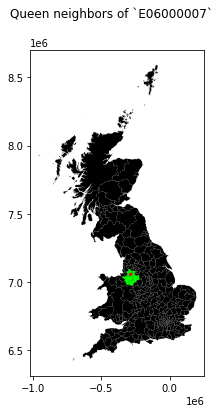

In [24]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
br.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = br.loc[['E06000007'], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = br.loc[w_queen['E06000007'], :]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
f.suptitle("Queen neighbors of `E06000007`")
plt.show()

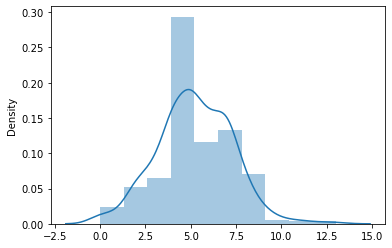

In [21]:
sns.distplot(queen_card, bins=10);

El histograma anterior señala que el número de vecinos promedios de cada observación está alrededor de 5, y que el máximo número de vecinos de una observación corresponde a 13 y que existen observaciones sin vecinos, es decir sola y separada del resto. Lo cual se puede verificar a continuación:

In [22]:
w_queen.max_neighbors

13

In [23]:
w_queen.islands

['E06000046', 'E06000053', 'S12000013', 'S12000023', 'S12000027', 'W06000001']

The cell where we computed $W$ returned a warning on "islands". Remember these are islands not necessarily in the geographic sense (although some of them will be), but in the mathematical sense of the term: local authorities that are not sharing border with any other one and thus do not have any neighbors. We can inspect and map them to get a better sense of what we are dealing with:

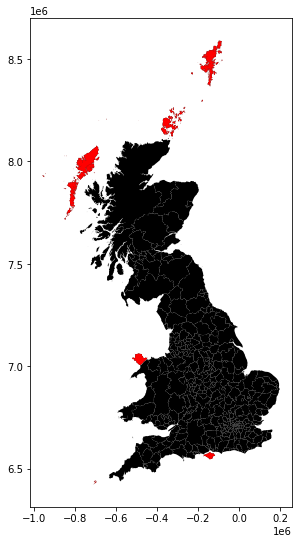

In [50]:
ax = br.plot(color='k', figsize=(9, 9))
br.loc[w_queen.islands, :].plot(color='red', ax=ax);

In this case, all the islands are indeed "real" islands. These cases can create issues in the analysis and distort the results. There are several solutions to this situation such as connecting the islands to other observations through a different criterium (e.g. nearest neighbor), and then combining both spatial weights matrices. For convenience, we will remove them from the dataset because they are a small sample and their removal is likely not to have a large impact in the calculations.

Technically, this amounts to a subsetting, very much like we saw in the first weeks of the course, although in this case we will use the `drop` command, which comes in very handy in these cases:

In [51]:
br = br.drop(w_queen.islands)

Once we have the set of local authorities that are not an island, we need to re-calculate the weights matrix:

In [52]:
# Create the spatial weights matrix
w = weights.Queen.from_dataframe(br, idVariable='LAD14CD')

And, finally, let us row-standardize it to make sure every row of the matrix sums up to one:

In [53]:
# Row standardize the matrix
w.transform = 'R'

Now, because we have row-standardize them, the weight given to each of the four neighbors is 0.2 which, all together, sum up to one.

In [54]:
w['E08000012']

{'E06000006': 0.2,
 'E08000011': 0.2,
 'E08000015': 0.2,
 'E08000014': 0.2,
 'E06000050': 0.2}

### Matriz de pesos basada en distancias

Las matrices de pesos basadas en la distancia asignan los pesos de acuerdo con dicha distancia. Es importante para este tipo de análisis contar con los datos proyectados a un sistema de coordenadas planas y no geográfico, de tal forma que permita medir distancias. Para este caso se debe reproyectar:

In [25]:
imd=br.to_crs(epsg=27700)

Para el caso del método de vecino mas cercano (KNN) se debe ingresar como argumento el número de vecinos a considerar. 

In [27]:
knn5 = weights.KNN.from_dataframe(imd, k=5)
knn5['E06000007']

{'E06000006': 1.0,
 'E08000013': 1.0,
 'E08000009': 1.0,
 'E08000010': 1.0,
 'E08000006': 1.0}

In [28]:
knn5.weights['E06000007']

[1.0, 1.0, 1.0, 1.0, 1.0]

In [29]:
knn5.neighbors['E06000007']

['E06000006', 'E08000013', 'E08000009', 'E08000010', 'E08000006']

In [30]:
knn5_card = pd.Series(knn5.cardinalities)
knn5_card.head(10)

E06000001    5
E06000002    5
E06000003    5
E06000004    5
E06000005    5
E06000006    5
E06000007    5
E06000008    5
E06000009    5
E06000010    5
dtype: int64

Otra forma de hacerlo es identificar manualmente el centroide de cada poligono.

In [31]:
cents = imd.centroid
pts = np.array([(pt.x, pt.y) for pt in cents]) # Extract coordinates into an array
knn5_from_pts = weights.KNN.from_array(pts, k=5) # Compute KNN weights
knn5_from_pts

Para conocer el número de vecinos en una distancia dada se utiliza el método de Bandas, donde a cada observación dentro del rango establecido se le asigna un peso igual al inverso de la distancia:

$$
w_{ij} = \dfrac{1}{d_{ij}}
$$

In [39]:
w_dist50kmB = weights.DistanceBand.from_dataframe(imd, 50000)

In [40]:
w_dist50kmB['E06000007']

{'E06000006': 1.0,
 'E06000008': 1.0,
 'E06000049': 1.0,
 'E06000050': 1.0,
 'E07000037': 1.0,
 'E07000117': 1.0,
 'E07000118': 1.0,
 'E07000119': 1.0,
 'E07000120': 1.0,
 'E07000123': 1.0,
 'E07000125': 1.0,
 'E07000126': 1.0,
 'E07000127': 1.0,
 'E07000195': 1.0,
 'E08000001': 1.0,
 'E08000002': 1.0,
 'E08000003': 1.0,
 'E08000004': 1.0,
 'E08000005': 1.0,
 'E08000006': 1.0,
 'E08000007': 1.0,
 'E08000008': 1.0,
 'E08000009': 1.0,
 'E08000010': 1.0,
 'E08000011': 1.0,
 'E08000012': 1.0,
 'E08000013': 1.0,
 'E08000014': 1.0,
 'E08000015': 1.0,
 'W06000005': 1.0}

In [41]:
w_dist50kmC = weights.DistanceBand.from_dataframe(imd, 50000, binary=False)

In [42]:
w_dist50kmC['E06000007']

{'E06000006': 8.329860278843111e-05,
 'E06000008': 3.0028321643294143e-05,
 'E06000049': 3.548816060468974e-05,
 'E06000050': 4.015427757479157e-05,
 'E07000037': 2.175664883027904e-05,
 'E07000117': 2.0850740643018106e-05,
 'E07000118': 3.3609688075961276e-05,
 'E07000119': 2.0405911604693417e-05,
 'E07000120': 2.4006210536332285e-05,
 'E07000123': 2.1369140954130304e-05,
 'E07000125': 2.6146250477470806e-05,
 'E07000126': 2.6381508522990962e-05,
 'E07000127': 3.1666293230041456e-05,
 'E07000195': 2.083196645230684e-05,
 'E08000001': 4.759810994921764e-05,
 'E08000002': 3.727398720196612e-05,
 'E08000003': 4.391855591128467e-05,
 'E08000004': 2.626773678904094e-05,
 'E08000005': 2.7617774905611036e-05,
 'E08000006': 6.120206641739688e-05,
 'E08000007': 3.452418619344428e-05,
 'E08000008': 2.906865957567783e-05,
 'E08000009': 7.129303100480003e-05,
 'E08000010': 7.117271649207412e-05,
 'E08000011': 5.490987586575155e-05,
 'E08000012': 4.25500161957151e-05,
 'E08000013': 7.9412232674840

La forma grafica del anterior análisis se puede ejecutar de la siguiente forma:

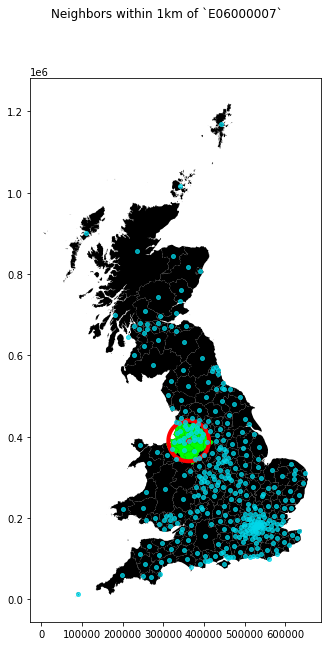

In [48]:
# Setup figure
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot base layer of polygons
imd.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = imd.loc[['E06000007'], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = imd.loc[w_dist50kmC['E06000007'], :]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Plot 1km buffer
buf = focus.centroid.buffer(50000)
buf.plot(edgecolor='red', facecolor='none', ax=ax, linewidth=4)
# Plot centroids of neighbor
pts = np.array([(pt.x, pt.y) for pt in imd.centroid])
ax.plot(pts[:, 0], pts[:, 1], color='#00d8ea', 
        linewidth=0, alpha=0.75, marker='o', markersize=4)
# Title
f.suptitle("Neighbors within 1km of `E06000007`")
# Style, zoom and display on screen
#ax.set_ylim(388000, 393500)
#ax.set_xlim(336000, 339500)
plt.show()

### Spatial lag

El *spatial lag* de una variable es el prodcuto de la matriz de pesos con la variable misma.

$$
Y_{sl} = W Y
$$
 
Donde 𝑌  es un vector Nx1 con los valores de la variable.

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

Once we have the data and the spatial weights matrix ready, we can start by computing the spatial lag of the percentage of votes that went to leave the EU. Remember the spatial lag is the product of the spatial weights matrix and a given variable and that, if $W$ is row-standardized, the result amounts to the average value of the variable in the neighborhood of each observation.

We can calculate the spatial lag for the variable `Pct_Leave` and store it directly in the main table with the following line of code:

In [14]:
br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])

Let us have a quick look at the resulting variable, as compared to the original one:

In [15]:
br[['LAD14NM', 'Pct_Leave', 'w_Pct_Leave']].head()

,LAD14NM,Pct_Leave,w_Pct_Leave
LAD14CD,,,
E06000001,Hartlepool,69.57,61.823333
E06000002,Middlesbrough,65.48,60.526667
E06000003,Redcar and Cleveland,66.19,62.486000
E06000004,Stockton-on-Tees,61.73,61.438333
E06000005,Darlington,56.18,57.430000


The way to interpret the spatial lag (`w_Pct_Leave`) for say the first observation is as follow: Hartlepool, where 69,6% of the electorate voted to leave is surrounded by neighbouring local authorities where, on average, almost 62% of the electorate also voted to leave the EU. For the purpose of illustration, we can in fact check this is correct by querying the spatial weights matrix to find out Hartepool's neighbors: 

In [16]:
w.neighbors['E06000001']

['E06000047', 'E06000003', 'E06000004']

And then checking their values:

In [17]:
neis = br.loc[w.neighbors['E06000001'], 'Pct_Leave']
neis

LAD14CD
E06000047    57.55
E06000003    66.19
E06000004    61.73
Name: Pct_Leave, dtype: float64

And the average value, which we saw in the spatial lag is 61.8, can be calculated as follows:

In [18]:
neis.mean()

61.82333333333333

In order to easily compare different scatter plots and spot outlier observations, it is common practice to standardize the values of the variable before computing its spatial lag and plotting it. This can be accomplished by substracting the average value and dividing the result by the standard deviation:

$$
z_i = \dfrac{y - \bar{y}}{\sigma_y}
$$

Standardizing means to substract the average value and divide by the standard deviation each observation of the column. This can be done easily with a bit of basic algebra in Python:

In [19]:
br['Pct_Leave_std'] = (br['Pct_Leave'] - br['Pct_Leave'].mean()) / br['Pct_Leave'].std()

Finally, to be able to explore the spatial patterns of the standardized values, also called sometimes $z$ values, we need to create its spatial lag:

In [20]:
br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])

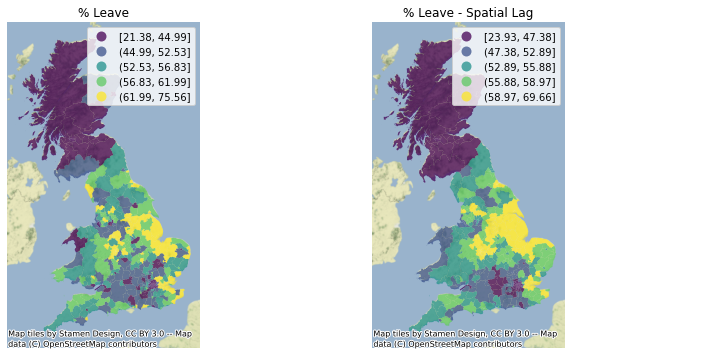

In [21]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

br.plot(column='Pct_Leave', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("% Leave")
ctx.add_basemap(ax1, 
                       crs=br.crs, 
                       source=ctx.providers.Stamen.TerrainBackground,
                       
                      )

br.plot(column='w_Pct_Leave', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
ctx.add_basemap(ax2, 
                       crs=br.crs, 
                       source=ctx.providers.Stamen.TerrainBackground,)

plt.show()

Stark differences on the left between immendiate neighbors (as in the case of Liverpool, in the NW of England) are diminished on the map in the right.

## Global Spatial autocorrelation

The map above is a good way to begin exploring the main spatial patterns in the data. At first sight, it appears to display a fair amount of positive spatial autocorrelation: local authorities with high percentages of votes to leave the EU tend to be next to each other (see, for instance, the eastern region), as are those where a much smaller proportion of their population voted to leave (with Scotland being a good example in the north). Humans however are very good pattern detectors. All over our history since we started as a species, life has rewarded pattern recognition abilities and punished individuals lacking it. Think of the advantage our ancestors had if they were able to spot particular shapes or movement when haunting, or the trouble they could get into if they were not able to recognize certain others in the darkness of night in the jungle. This extraordinary capability to spot trends, patterns and associations tends to also create many false positives: cases where we think there is a pattern but in fact what we are seeing is largely random. This is particularly accentuated in the case of maps where, as we have seen in the choropleth mapping chapter, the shape of geometries can also significantly distort our perception. By looking at the map above, for example, we can have an educated guess about the presence of spatial autocorrelation; but actually determining whether what we are seeing could have come from pure chance or not is usually easier said than done.

That is exactly the purpose of indicators of global spatial autocorrelation: to leverage the power of statistics to help us first summarize the spatial distribution of values present in a map, and second obtain a formal quantification of the departure from randomness. Statistics designed to measure this trend thus characterize a map in terms of its degree of clustering and summarize it, either in a visual or numerical way. However, before we can delve into the statistics, we need to understand a core building block: the spatial lag. With that concept under the belt, we are in a position to build a good understanding of global spatial autocorrelation. We will gently enter it with the binary case, when observations can only take two (potentially categorical) values, before we cover the two workhorses of the continous case: the Moran Plot and Moran’s I.

## Binary case: join counts¶
The spatial lag plays an important role in quantifying spatial autocorrelation. Using it, we can begin to put in relation the behaviour of a variable at a given location with its pattern in the immediate neighbourhood. Measures of global spatial autocorrelation will then use each observation to construct overall measures about the general trend in a given dataset.

Our first dip into these measures considers a simplified case: binary values. This occurs when the variable we are interested in only takes two values. In this context, we are interested in whether a given observation is surrounded by others within the same category. For example, returning to our dataset, we want to assess the extent to which local authorities who voted to Leave tend to be surrounded by others who also voted to leave. To proceed, let us first calculate a binary variable (Leave) that indicates 1 if the local authority voted to leave, and zero otherwise:

In [22]:
br['Leave'] = (br['Pct_Leave'] > 50).astype(int)
br[['Pct_Leave', 'Leave']].tail()

,Pct_Leave,Leave
LAD14CD,,
W06000020,59.78,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1
W06000024,56.44,1


Which we can visualise readily:

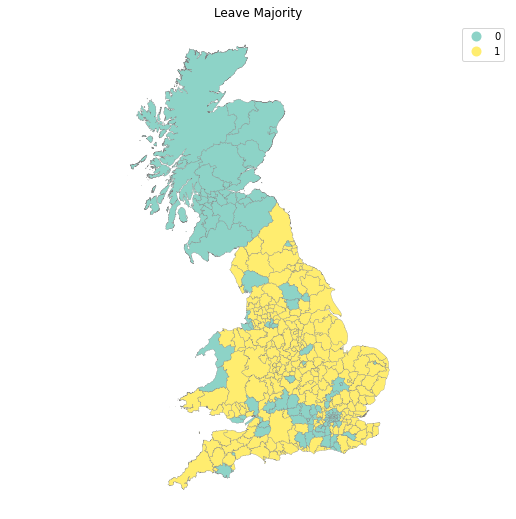

In [23]:
f, ax = plt.subplots(1, figsize=(9, 9))
br.plot(ax=ax, column='Leave', categorical=True, legend=True, 
        edgecolor='0.5', linewidth=0.25, cmap='Set3', 
        figsize=(9, 9));
ax.set_axis_off()
ax.set_title('Leave Majority')
plt.axis('equal')
plt.show()

Visually, it appears that the map represents a clear case of positive spatial autocorrelation: overall, there are few visible cases where a given observation is surrounded by others in the opposite category. To formally explore this initial assessment, we can use what is called a “join count” statistic (JC; [CO81]). Imagine a checkerboard with green (G, value 0) and yellow (Y, value 1) squares. The idea of the statistic is to count occurrences of green-green (GG), yellow-yellow (YY), or green-yellow/yellow-green (GY) joins (or neighboring pairs) on the map. In this context, both GG and YY reflect positive spatial autocorrelation, while GY captures its negative counterpart. The intuition of the statistic is to provide a baseline of how many GG, YY, and GY one would expect under the case of complete spatial randomness, and to compare this with the observed counts in the dataset. A situation where we observe more GG/YY than expected and less GY than expected would suggest positive spatial autocorrelation; while the oposite, more GY than GG/YY, would point towards negative spatial autocorrelation.

Since the spatial weights are only used here to delimit who is a neighbor or not, the join count statistic requires binary weights. Let us thus transform w back to a non-standardised state:

In [74]:
w.transform

'R'

In [75]:
w.transform = 'O'

In [76]:
w.transform

'O'

We can compute the statistic as:

In [79]:
jc = esda.join_counts.Join_Counts(br['Leave'], w)
jc

As it is common throughout PySAL, we are creating an object (jc) that holds a lot of information beyond the value of the statistic calculated. For example, we can check how many occurrences of GG we have (note the attribute is bb, which originates from the original reference where the two considered classes were black and white):

In [80]:
jc.bb

580.0

how many YY occurrences our map has:

In [81]:
jc.ww

191.0

and how many GY/YG we find:

In [82]:
jc.bw

220.0

The sum of those three gives us the total number of comparisons:

In [83]:
jc.bb + jc.ww + jc.bw

991.0

In [84]:
jc.J

991.0

The statistic is based on comparing the actual number of joins of each class (bb, ww, bc) with what one would expect in a case of spatial randomness. Those expectations can be accessed as well, for the GG/YY case:

In [85]:
jc.mean_bb

482.2352352352352

and for GY joins:

In [86]:
jc.mean_bw

418.8538538538539

Statistical inference to obtain a sense of whether these values are likely to come from random chance or not can be accessed as:

In [87]:
jc.p_sim_bb

0.001

In [88]:
jc.p_sim_bw

1.0

These results point to a clear presence of positive spatial autocorrelation, as there are a lot more joins of pairs in the same category than one would expect (p_sim_bb) and significantly less of opposite joins (p_sim_bw).

### Moran Plot

The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by substracting its mean and dividing it by its standard deviation.

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot in Python, provided we have standardized the variable and calculated its spatial lag beforehand:

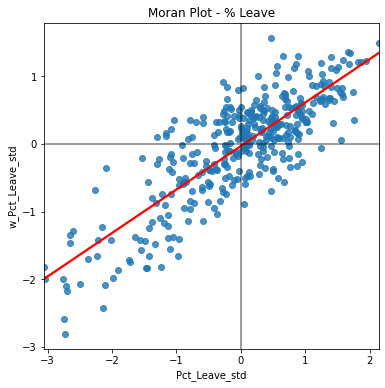

In [27]:
br['Pct_Leave_std'] = ( br['Pct_Leave'] - br['Pct_Leave'].mean() )\
                    / br['Pct_Leave'].std()
br['Pct_Leave_lag_std'] = ( br['w_Pct_Leave_std'] - br['w_Pct_Leave_std'].mean() )\
                    / br['w_Pct_Leave_std'].std()

f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', 
                ci=None, data=br, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

Otra forma de obtener esta gráfica es:

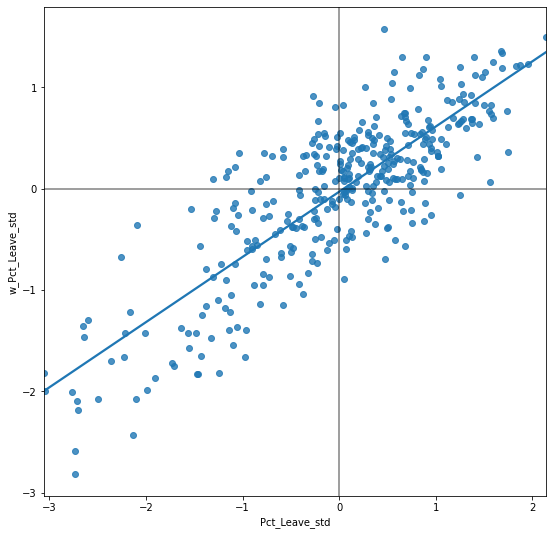

In [28]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

The figure above displays the relationship between the standardized percentage which voted to Leave the EU (`Pct_Leave_std`) and its spatial lag which, because the $W$ that was used is row-standardized, can be interpreted as the average percentage which voted to Leave in the surrounding areas of a given Local Authority. In order to guide the interpretation of the plot, a linear fit is also included in the post. This line represents the best linear fit to the scatter plot or, in other words, what is the best way to represent the relationship between the two variables as a straight line. 

The plot displays a positive relationship between both variables. This is associated with the presence of *positive* spatial autocorrelation: similar values tend to be located close to each other. This means that the *overall trend* is for high values to be close to other high values, and for low values to be surrounded by other low values. This however does not mean that this is only situation in the dataset: there can of course be particular cases where high values are surrounded by low ones, and viceversa. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space.

In the context of the example, this can be interpreted along the lines of: local authorities display positive spatial autocorrelation in the way they voted in the EU referendum. This means that local authorities with high percentage of Leave voters tend to be located nearby other local authorities where a significant share of the electorate also voted to Leave, and viceversa.

### Moran's I

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarizes the figure. This is exactly what Moran's I is meant to do. 

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is an even close connection between the two: the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.

In order to calculate Moran's I in our dataset, we can call a specific function in `PySAL` directly:

In [29]:
mi = esda.Moran(br['Pct_Leave'], w)

Note how we do not need to use the standardized version in this context as we will not represent it visually.

The method `ps.Moran` creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:

In [30]:
mi.I

0.6431732058159241

The other bit of information we will extract from Moran's I relates to statistical inference: how likely is the pattern we observe in the map and Moran's I captures in its value to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics?

The specific details of the mechanism to calculate this are beyond the scope of the session, but it is important to know that a small enough p-value associated with the Moran's I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern that we would expect if the values had been randomly allocated to a particular location.

The most reliable p-value for Moran's I can be found in the attribute `p_sim`:

In [25]:
mi.p_sim

0.001

The value is calculated as an empirical P-value that represents the proportion of realisations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran’s I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

That is a very low value, particularly considering it is actually the minimum value we could have obtained given the simulation behind it used 999 permutations (default in PySAL) and, by standard terms, it would be deemed statistically significant. We can ellaborate a bit further on the intuition behind the value of p_sim. If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.01% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.99% of the random maps would receive a smaller (absolute) value of Moran’s I. If we remember again that the value of Moran’s I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values over space we observe for the percentage of Leave votes is more concentrated than if we were to randomly shuffle the vote proportions among the map, hence the statistical significance. As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively autocorrelated over space. Indeed, the overall spatial pattern in the EU Referendum vote was highly marked: nearby areas tended to vote alike.

Thanks to the splot visualisation module in PySAL, we can obtain a quick representation of the statistic that combines the Moran Plot (right) with a graphic of the empirical test that we carry out to obtain p_sim (left):

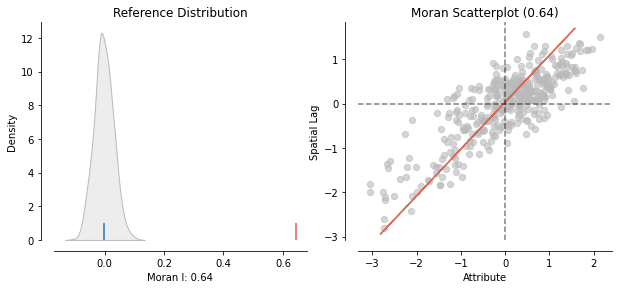

In [32]:
from pysal.viz import splot
from splot.esda import plot_moran
plot_moran(mi);

On the left panel we can see in grey the empirical distribution generated from simulating 999 random maps with the values of the Pct_Leave variable and then calculating Moran’s I for each of those maps. The blue rug signals the mean. In contrary, the red rug shows Moran’s I calculated for the variable using the geography observed in the dataset. It is clear the value under the observed pattern is significantly higher than under randomness. This insight is confirmed on the right panel, where there is displayed an equivalent plot to the Moran Plot we created above.

### Other global indices

#### Geary's C
​
The contiguity ratio $c$, proposed by {cite}`Geary1954contiguity`, is given by:
​
$$
C = \dfrac{(n-1)}
          {2 \sum_i \sum_j w_{ij}} 
    \dfrac{\sum_i \sum_j w_{ij} (y_i - y_{j})^2}
          {\sum_i (y_i - \bar{y})^2}
$$
where  𝑛  is the number of observations,  𝑤𝑖𝑗  is the cell in a binary matrix  𝑊  expressing whether  𝑖  and  𝑗  are neighbours ( 𝑤𝑖𝑗=1 ) or not ( 𝑤𝑖𝑗=1 ),  𝑦𝑖  is the  𝑖 -th observation of the variable of interest, and  𝑦¯  is its sample mean. When compared to Moran's I, it is apparent both measures put in relation the behaviour of  𝑌  within each observation's local neighbourhood with that over the entire sample. However, there are also subtle differences. While Moran's I takes cross-products on the standardised values, Geary's C uses differences on the values without any standardisation.

Computationally, Geary's C is more demanding, but it can be easily computed using PySAL:

In [33]:
geary = esda.geary.Geary(br['Pct_Leave'], w)

Which has a similar way of accessing its estimate:

In [34]:
geary.C

0.3241572123881239

Inference is performed in a similar way as with Moran. We can perform a simulation that allows us to draw an empirical distribution of the statistic under the null of spatial randomness, and then compare it with the statistic obtained when using the observed geographical distribution of the data. To access the pseudo p-value, calculated as in the Moran case, we can call `p_sim`:

In [35]:
geary.p_sim

0.001

In this case, Geary's C points in the same direction as Moran's I: there is clear indication that the statistic we calculate on the observed dataset is different from what would be expected in a situation of pure spatial randomness. Hence, from this analysis, we can also conclude spatial autocorrelation is present.

#### Getis and Ord's G

Originally proposed by {cite}`Getis1992analysis`, the $G$ is the global version of a family of statistics of spatial autocorrelation based on distance. The $G$ class of statistics is conceived for points, hence the use of a distance $W$, but it can also be applied to lattice data if a binary spatial weights matrix can be constructed. Additionally, it is designed for the study of positive variables with a natural origin. The $G$ can be expressed as follows:

$$
G(d) = \dfrac{ \sum_i \sum_j w_{ij}(d) \, y_i \, y_j }
             { \sum_i \sum_j y_i \, y_j }
$$

where $w_{ij}(d)$ is the binary weight assigned on the relationship between observations $i$ and $j$ following a distance band criterium. $G$ was originally proposed as a measure of concentration rather than of spatial autocorrelation. As such, it is well suited to test to what extent similar values (either high or low) tend to co-locate. In other words, the $G$ is a statistic of *postive* spatial autocorrelation. This is usually the interest in most Geographic Data Science applications. However, it is important to note that, because $G$ can be understood as a measure of the intensity with which $Y$ is concentrated, the statistic is not able to pick up cases of *negative* spatial autocorrelation.

To illustrate its computation, let us calculate a binary distance band $W$. To make sure every observation has at least one neighbor, we will use the `min_threshold_distance` method and project the dataset into the Ordnance Survey CRS (`EPSG` code 27700), expressed in metres:

In [37]:
br_osgb = br.to_crs(epsg=27700)
pts = br_osgb.centroid
xys = pd.DataFrame({'X': pts.x, 'Y': pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

90746.35776376339

For every local authority to have a neighbour, the distance band needs to at least be about 181 Km. This information can then be passed to the `DistanceBand` constructor:

In [39]:
w_db = weights.DistanceBand.from_dataframe(br_osgb, min_thr)

At this point, we are ready to calculate the global $G$ statistic:

In [41]:
gao = esda.getisord.G(br['Pct_Leave'], w_db)

Access to the statistic (`gao.G`) and additional attributes can be gained in the same way as with the previous statistics:

In [42]:
print("Getis & Ord G: %.3f | Pseudo P-value: %.3f"%(gao.G, gao.p_sim))

Getis & Ord G: 0.162 | Pseudo P-value: 0.030


Similarly, inference can also be carried out by relying on computational simulations that replicate several instances of spatial randomness using the values in the variable of interest, but shuffling their locations. In this case, the pseudo P-value computed suggests a clear departure from the hypothesis of no concentration.

## Local Spatial autocorrelation

In the previous chapter we explored the use of global measures of spatial autocorrelation to ask the question of whether the overall spatial distribution of our attribute of interest was reflective of a geographically random process, or not. These statistics are useful as the presence of spatial autocorrelation has important implications for subsequent statistical analysis. From a substantive perspective, spatial autocorrelation could reflect the operation of processes that generate association between the values in nearby locations. In these cases formal modeling of the spatial dimensions of the processes should next be carried out. On the other hand, spatial autocorrelation can sometimes arise from data processing operations in which cases the dependence is a form of non-random noise rather than due to substantive processes. Irrespective of whether the spatial autocorrelation is due to substantive or nuisance sources, it is a form of non-randomness that complicates statistical anaylsis.

For these reasons the ability to determine whether spatial autocorrelation is present in a geographically referenced data set is a critical component of the spatial data science toolbox. That said, the global measures of spatial autocorrelation are “whole map” statistics, meaning that the single statistic pertains to the complete data set. In other words, global autocorrelation statistics allow us to detect clustering in a geographically referenced dataset. For example, Moran’s I is good tool to summarize a dataset into a single value that informs about its degree of geographical clustering. However, it is not an appropriate measure to identify areas within the map where specific types of values (e.g. high, low) are located. In other words, Moran’s I can tell us values are clustered overall, but it will not inform us about where the clusters are. For that purpose, we need to use a local measure of spatial autocorrelation. Local measures consider each single observation and operate on them, as oposed to on the overall dataset, as global measures do. Because of that, they are not good at summarizing a map, but they allow to obtain further insights about interesting geographical subsets of the data. In this chapter, we consider [Local Indicators of Spatial Association](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x/abstract) (LISAs), a local counter-part of global measures like Moran's I. At the core of these method is a classification of the observations in a dataset into four groups derived from the Moran Plot: high values surrounded by high values (HH), low values nearby other low values (LL), high values among low values (HL), and viceversa (LH). Each of these groups are typically called "quadrants". An illustration of where each of these groups fall into the Moran Plot can be seen below:

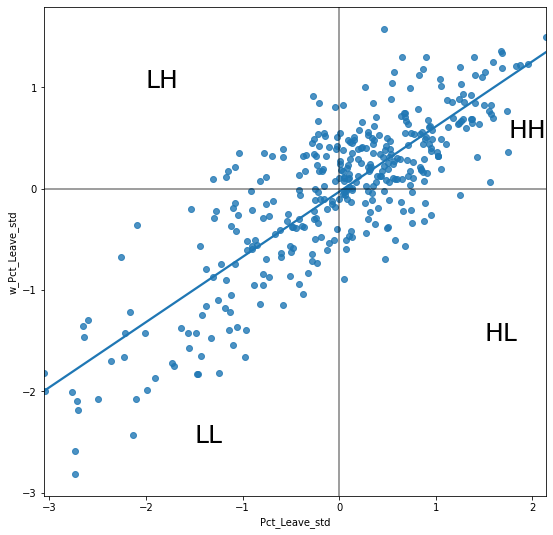

In [43]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying areas of unusual concentration of values. To know whether each of the locations is a *statistically significant* cluster of a given kind, we again need to compare it with what we would expect if the data were allocated in a completely random way. After all, by definition, every observation will be of one kind of another, based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high. 

This is exactly what LISAs are designed to do. As before, a more detailed description of their statistical underpinnings is beyond the scope in this context, but we will try to shed some light into the intuition of how they go about it. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as many statistics as original observations.

De esta forma la gráfica de Moran queda centrada en el plot, partiendo el espacio en cuadrantes que representan:

* High-High (HH): valores por encima de la media rodeado por valores por encima de la media.
* Low-Low (LL): valores por debajo de la media rodeado por valores por debajo de la media.
* High-Low (HL): valores por encima de la media rodeado por valores por debajo de la media.
* Low-High (LH): valores por debajo de la media rodeado por valores por encima de la media.

LISAs are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide *suggestive* evidence about the processes that might be at work. For that, they have a prime place in the exploratory toolbox. Examples of contexts where LISAs can be useful include: identification of spatial clusters of poverty in regions, detection of ethnic enclaves, delineation of areas of particularly high/low activity of any phenomenon, etc.

In Python, we can calculate LISAs in a very streamlined way thanks to `PySAL`:

In [44]:
lisa = esda.Moran_Local(br['Pct_Leave'], w)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

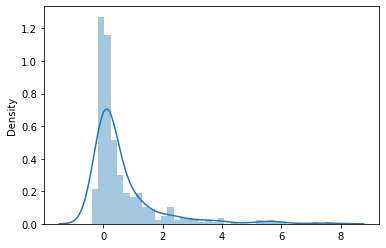

In [53]:
sns.distplot(lisa.Is)

This reveals a rather skewed distribution due to the dominance of the positive forms of spatial association. Here it is important to keep in mind that the high positive values arise from value simularity in space, and this can be due to either high values being next to high values or low values next to low values. The local Ii values themselves cannot distinguish between these two.

The values in the left tail of the density represent locations displaying negative spatial association. There are also two forms, a high value surrounded by low values, or a low value surrounded by high valued neighboring observations. And, again, the Ii value cannot distinguish between the two cases.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember we are calculating a statistic for every single observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. In this context, a choropleth can help. At first glance, this may seem to suggest that a map of the Ii values would be a useful way to visualize the spatial distribution:

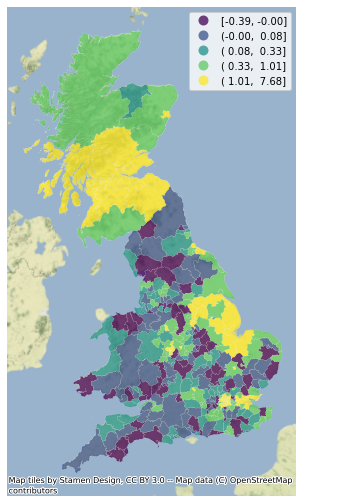

In [55]:
f, ax = plt.subplots(1, figsize=(9,9))
br['Is'] = lisa.Is
br.plot(column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
ctx.add_basemap(ax, 
                       crs=br.crs, 
                       source=ctx.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

However, this does not inform us in any way about what type of spatial correlation each area is experiencing. For example, are the yellow areas in Scotland similar to those in the East cluster of high values too? Also, we know that values around zero will not be statistically significant. Which ones are thus significant and non-significant from a statistical point of view? In other words, which ones can be considered statistical clusters and which ones noise? To answer these questions, we need to bring in additional information that we have obtained when calculating the LISA statistics. Let us first build a four-plot figure that brings all these different perspectives together:

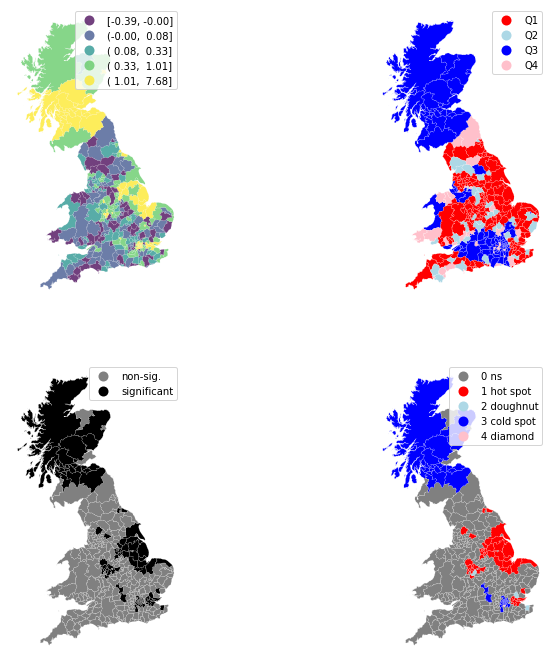

In [60]:
from matplotlib.colors import ListedColormap
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
br.plot(column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)
ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
br.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
br.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()
                            
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = ListedColormap([ 'grey', 'red', 'lightblue', 'blue', 'pink'])


br.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()


# Display the figure
plt.show()

The figure in the upper-left replicates our first map above. The green and yellow locations have the largest values for the local statistics, yet this does not distinguish between positive association of low support for the Brexit vote and positive association of high support for Brexit.

To distinguish between these two cases, the map in the upper-right shows the location of the LISA statistic in the quadrant of the Moran Scatter plot, which is recorded in the q attribute:

All we need to pass is the variable of interest -percentage of Leave votes- and the spatial weights that describes the neighborhood relations between the different observation that make up the dataset.

In [45]:
# Break observations into significant or not
br['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
br['quadrant'] = lisa.q

Let us stop for second on these two steps. First, the `significant` column. Similarly as with global Moran's I, `PySAL` is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Following a similar reasoning as with global Moran's I, we select 5% as the threshold for statistical significance. To identify these values, we create a variable, `significant`, that contains `True` if the p-value of the observation is satisfies the condition, and `False` otherwise. We can check this is the case:

In [46]:
br['significant'].head()

LAD14CD
E06000001    False
E06000002    False
E06000003     True
E06000004     True
E06000005    False
Name: significant, dtype: bool

And the first five p-values can be checked by:

In [47]:
lisa.p_sim[:5]

array([0.082, 0.117, 0.015, 0.02 , 0.222])

Note how the third and fourth are smaller than 0.05, as the variable `significant` correctly identified.

Second, the quadrant each observation belongs to. This one is easier as it comes built into the `lisa` object directly:

In [48]:
br['quadrant'].head()

LAD14CD
E06000001    1
E06000002    1
E06000003    1
E06000004    1
E06000005    1
Name: quadrant, dtype: int64

The correspondence between the numbers in the variable and the actual quadrants is as follows:

* 1: HH
* 2: LH
* 3: LL
* 4: HL

With these two elements, `significant` and `quadrant`, we can build a typical LISA cluster map combining the mapping skills with what we have learned about subsetting and querying tables:

We can create a quick LISA cluster map with `splot`:

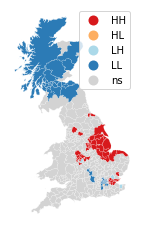

In [51]:
from splot.esda import lisa_cluster
lisa_cluster(lisa, br);

Or, if we want to have more control over what is being displayed, and how each component is presented, we can "cook" the plot ourselves:

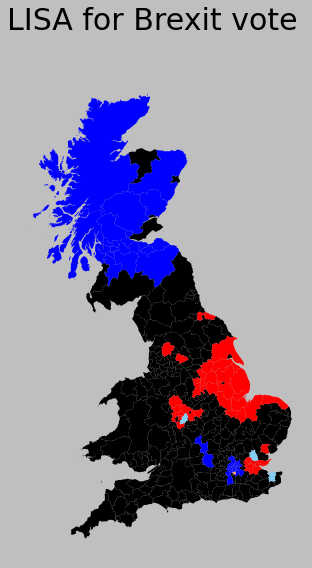

In [52]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot insignificant clusters
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')
# Plot HH clusters
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')
# Plot LL clusters
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')
# Plot LH clusters
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4')
# Plot HL clusters
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696')
# Style and draw
f.suptitle('LISA for Brexit vote', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.show()

The map above displays the LISA results of the Brexit vote. In bright red, we find those local authorities with an unusual concentration of high Leave voters surrounded also by high levels of Leave vote. This corresponds with areas in the East of England, the Black Country, and East of London. In light red, we find the first type of *spatial outliers*. These are areas with high Leave vote but surrounded by areas with low support for leaving the EU (e.g. central London). Finally, in light blue we find the other type of spatial outlier: local authorities with low Leave support surrounded by other authorities with high support.

The substantive interpretation of a LISA map needs to relate its output to the original intention of the analyst who created the map. In this case, our original idea was to explore the spatial structure of support to leaving the EU. The LISA proves a fairly useful tool in this context. Comparing the LISA map above with the choropleth we started with, we can interpret the LISA as "simplification" of the detailed but perhaps too complicated picture in the choropleth that focuses the reader's attention to the areas that display a particularly high concentration of (dis)similar values, helping the spatial structure of the vote emerge in a more explicit way. The result of this highlights the relevance that the East of England and the Midlands had in voting to Leave, as well as the regions of the map where there was a lot less excitement about Leaving.

The results from the LISA statistics can be connected to the Moran plot to visualise where in the scatter plot each type of polygon falls:

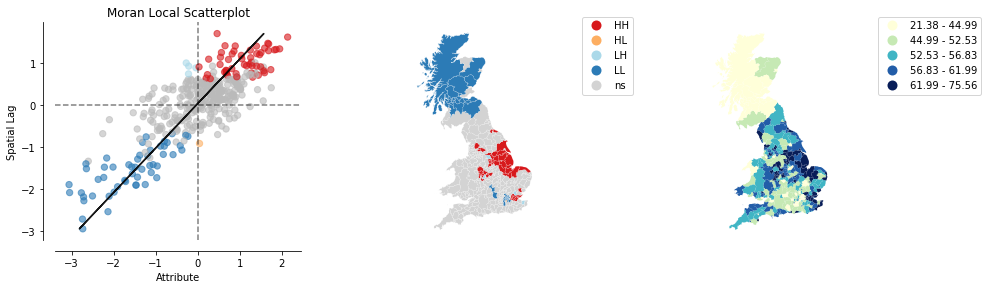

In [34]:
plot_local_autocorrelation(lisa, br, 'Pct_Leave');

## Other local indices

Similar to the global case, there are more local indicators of spatial correlation than the local Moran's I. `PySAL` includes Getis and Ord's $G_i$ and $G_i^*$, which differ only on whether to exclude the self-value in the calculation or not, respectively. The way to calculate them also follows similar patterns as with the LISA above. Let us see how that would look like for our Brexit example:

In [61]:
# Gi
gostats = esda.getisord.G_Local(br['Pct_Leave'], w)
# Gi*
gostars = esda.getisord.G_Local(br['Pct_Leave'], w, star=True)

As the local statistics they are, it is best to explore them by plotting them on a map. Unlike with LISA though, the $G$ statistics only allow to identify positive spatial autocorrelation. When standardized, positive values imply clustering of high values, while negative implies grouping of low values. Unfortunately, it is not possible to discern spatial outliers.

In this case, let us write a little function that generates the map so we can then easily use it to generate two maps, one for $G_i$ and one for $G_i^*$:

In [66]:
def g_map(g, geog, ax):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = br.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='grey', edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = br.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='red', edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = br.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='blue', edgecolor=ec, linewidth=0.1)
    # Style and draw
    ctx.add_basemap(ax, 
                           crs=br.crs, 
                           source=ctx.providers.Stamen.TerrainBackground,

                          )
    st = ''
    if g.star:
        st = '*'
    ax.set_title('G%s statistic for Pct of Leave votes'%st, size=15)
    ax.set_axis_off()
    return ax

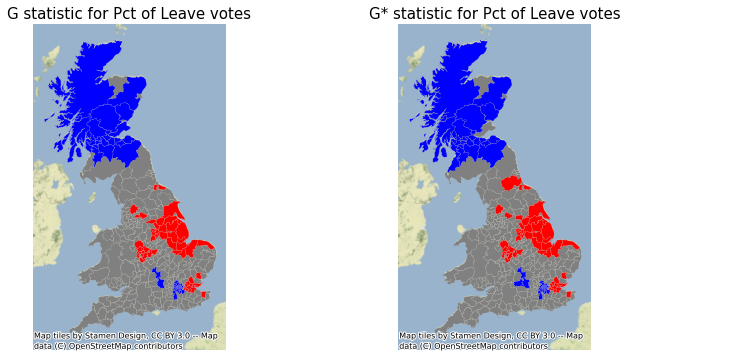

In [67]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics and generate the map
for g, ax in zip([gostats, gostars], axs.flatten()):
    ax = g_map(g, br, ax)
# Render
plt.show()

As you can see, the results are virtually the same for $G_i$ and $G_i^*$. Also, at first glance, these maps appear to be visually similar to the final LISA map from above, and this leads to the question of why use the $G$ statistics at all. The answer to this question is that the two sets of local statistics, Local $I$ and the local $G$, are complementary statistics. This is because the local $I$ by itself cannot distinguish between the two forms of positive spatial association while the G can. At the same time, the G statistic does not consider negative spatial association, while the local I statistic does.